Our baseline will be classificator + parapharser

In [18]:
import pandas as pd
data = pd.read_csv('../data/interim/words.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24645 entries, 0 to 24644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    24640 non-null  object
 1   target  24645 non-null  object
dtypes: object(2)
memory usage: 577.6+ KB


In [19]:
print(f'Number of words in dataset: {len(data)}')
print(f'Unique words in dataset: {len(data["word"].unique())}')
print(f'Nulls: {data["word"].isna().sum()}')

Number of words in dataset: 24645
Unique words in dataset: 12670
Nulls: 5


Drop rows without words and duplicate rows

In [20]:
data = data.dropna(subset=['word'])
data = data.drop_duplicates()

Same Words can be both negative and positive meanings based on context, which is why we categorize them as "Negative" to prevent False Positive identifications. This approach can enhance precision scores but may result in a decrease in recall, as it could lead to more instances of False Negatives. For our specific task, this is not particularly crucial, as we have the option to substitute positive words with alternative positive terms.

![Alt text](https://www.researchgate.net/publication/336402347/figure/fig3/AS:812472659349505@1570719985505/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix.ppm "a title")


In [21]:
data.loc[data['word'].duplicated(keep=False), 'target'] = 'Negative'
data = data.drop_duplicates()

In [22]:
print(f'Number of words in dataset: {len(data)}')
print(f'Unique words in dataset: {len(data["word"].unique())}')
print(f'Nulls: {data["word"].isna().sum()}')

Number of words in dataset: 12669
Unique words in dataset: 12669
Nulls: 0


Let's see the distribution of target value

<BarContainer object of 2 artists>

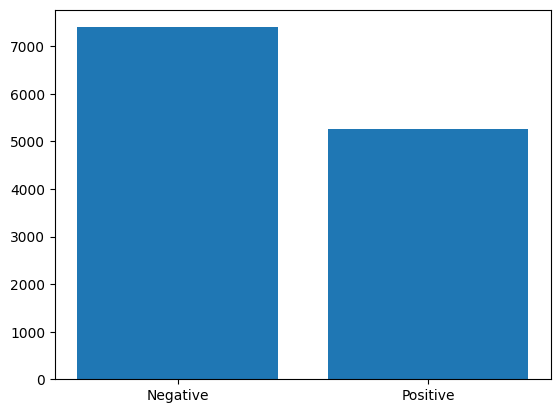

In [23]:
import matplotlib.pyplot as plt
target_counts = data['target'].value_counts()
target_counts.sort_index()
plt.bar(target_counts.index, target_counts.values)

In [24]:
from sklearn.model_selection import train_test_split
data['target'] = data['target'].replace({'Positive': 0, 'Negative': 1})
X_train, y_train = data['word'], data['target']

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import string
from nltk.tokenize import word_tokenize

def Preprocessor(text):
    
    if isinstance(text, list):
        text = pd.Series(text)

    if isinstance(text, pd.core.series.Series):
        return text.str.lower().str.strip()
    elif isinstance(text, str):
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.lower()
        tokenized = word_tokenize(text)
        return tokenized


classificator = Pipeline([
    ('preprocessor', FunctionTransformer(func=Preprocessor)),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

classificator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function Preprocessor at 0x29c31ad40>)),
                ('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [26]:
detox_data = pd.read_csv('../data/raw/filtered.tsv', sep='\t', index_col=0)
detox_data

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
...,...,...,...,...,...,...
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124


In [27]:
detox_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577777 entries, 0 to 577776
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reference    577777 non-null  object 
 1   translation  577777 non-null  object 
 2   similarity   577777 non-null  float64
 3   lenght_diff  577777 non-null  float64
 4   ref_tox      577777 non-null  float64
 5   trn_tox      577777 non-null  float64
dtypes: float64(4), object(2)
memory usage: 30.9+ MB


In [28]:
detox_data = detox_data[detox_data['ref_tox'] >= detox_data['trn_tox']]
detox_data

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...,0.703185,0.206522,0.950956,0.035846
6,"They're all laughing at us, so we'll kick your...",they're laughing at us. We'll show you.,0.618866,0.230769,0.999492,0.000131
7,Maine was very short on black people back then.,there wasn't much black in Maine then.,0.720482,0.187500,0.963680,0.148710
11,"So now their spirits are cursed, walking back ...","their souls are cursed, they guard the paths, ...",0.755883,0.013245,0.842509,0.143992
13,"Come on, Cal, leave that shit alone.","come on, Cal, put it down.",0.660481,0.270270,0.999637,0.000279
...,...,...,...,...,...,...
577770,I am so crazy nuts about you guys.,I'm so crazy about you guys.,0.934512,0.171429,0.973442,0.000709
577771,"I thought American men were bad enough, but no...","an American man is worth nothing, but for you,...",0.671444,0.371212,0.999624,0.035941
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049


In [29]:
from nltk.wsd import lesk
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')


def paraphraser(sentence):
    stop_words = set(stopwords.words('english'))

    def get_synonym_by_context(word, context_sentence):
        # Disambiguate the word in the context sentence
        sense = lesk(context_sentence, word)

        # Find synonyms for the disambiguated sense
        synonyms = []
        if sense:
            for lemma in sense.lemmas():
                synonyms.append(lemma.name().replace('_', ' '))

        # Remove duplicates and display the closest synonym
        synonyms = list(set(synonyms))
        if len(synonyms) == 0:
            synonyms.append(word)
        #rearrange synonyms by they toxicity
        synonyms = sorted([(synonym, classificator.predict_proba(synonym)[0, 1]) for synonym in synonyms], key= lambda x: x[1])
        return synonyms[0][0]

    tokenized = Preprocessor(sentence)
    predictions = classificator.predict(tokenized)
    mask = np.array([0 if word in stop_words else 1 for word in tokenized])
    predictions = predictions * mask
    assert len(predictions) == len(tokenized)
    paraphrased = [get_synonym_by_context(word, sentence) if predictions[i] == 1 else word for i, word in enumerate(tokenized)]
    return ' '.join(paraphrased)


[nltk_data] Downloading package punkt to /Users/adautov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adautov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
sentences = detox_data['reference'].iloc[:1].values

In [31]:
for sentence in sentences:
    print(sentence, paraphraser(sentence), end='\n\n',sep='\n')

I'm not gonna have a child... ...with the same genetic disorder as me who's gonna die. L...
im not gon sodium have a child with the same genetical disorderliness as me World Health Organization gon sodium die cubic decimeter



In [32]:
import sys
sys.path.insert(0, '../src/metric')
from metric import calculate_metric

N = 100
X, y_true = detox_data['reference'].values[:N], detox_data['translation'].values[:N]

print(X[1])
print(f'Pred: {paraphraser(X[1])}\nTrue: {y_true[1]}')


They're all laughing at us, so we'll kick your ass.
Pred: theyre all laughing at uranium so well kick your ass
True: they're laughing at us. We'll show you.


In [33]:
y_preds = []
for sentence in X:
   y_preds.append(paraphraser(sentence))

In [34]:
calculate_metric(y_true, y_preds)

Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:01<00:00,  2.36it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how

Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 221.45it/s]


Calculating CoLA acceptability stats


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.6500|0.5319|0.9400|0.3291|0.3953|



(0.65, 0.5318588982522487, 0.94, 0.3291400098800659, 0.3953042070502675)